# Problema de clasificación de Figuras
Tenemos una base de datos formada por 1400 imágenes binarias.
Existen 70 clases distintas, cada una de ellas compuesta por 20 imagenes.


1. Pasos previos

2. Selección de características

3. Selección del modelo

4. trabajo Futuro

5. Referencias

## 1. Pasos previos
Primero importamos todos las librerías que vamos a necesitar.

In [1]:
%matplotlib inline
from __future__ import division
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import glob,os, sys
from PIL import Image
from math import pi
from IPython.display import Latex
from IPython.display import Math

Definimos una función para convertir las imágenes de formato .gif a .png ya que las primeras no pueden ser usadas en OpenCV.

In [2]:
def convert_images():
    files = glob.glob("original/*.gif") 

    if not os.path.exists("converted"):
        os.makedirs("converted")

    for imageFile in files:
        filepath,filename = os.path.split(imageFile)
        filterame,exts = os.path.splitext(filename)
        print "Processing: " + imageFile,filterame
        im = Image.open(imageFile)
        im.save( 'converted/'+filterame+'.png','PNG')

## 2. Selección de características
Es esta sección vamos a analizar las figuras. Buscaremos diferencias entre figuras de distintas clases y similitudes entre figuras pertenecientes a la misma clase.

Las características que se han considerado son las siguientes.

- Solidity
- Proportion
- Convexity
- Rectangularity
- Circularity ratio
- Hu moment invariants
- Longitud del contorno aproximado
- Longitud del contorno de la envoltura convexa aproximada

#### Solidity

Esta característica representa la relación que existe entre el area de la figura y el area de la envoltura convexa. 

$Solidity = \dfrac{\mathit{Area}}{\mathit{AreaCovexHull}}$

#### Proportion
Esta característica nos indica como de alargadas son las figuras.

A partir del rectángulo de mínima área que contiene la figura, podemos calcular la __proporción__ de la figura con una división de sus lados. Para obtener un número entre 0 y 1 se ha realizado la división del lado menor entre el mayor.

$Proportion = \dfrac{\mathit{Shorter}}{\mathit{Longer}}$

#### Convexity
Esta característica nos indica el nivel de convexidad de la figura.

Se calcula dividiendo el perímetro de la envoltura convexa entre el perímetro de la figura.

$Convexity = \dfrac{\mathit{ConvexHullPerimeter}}{\mathit{Perimeter}}$

#### Rectangularity
Esta característica nos muestra el grado de similitud de la figura con el rectángulo de mínima area que contiene a la figura.

Para ello compara el area del rectángulo de area mínima con el area de la figura.

$Rectangularity = \dfrac{\mathit{Area}}{\mathit{AreaRectangle}}$

#### Circularity ratio

Considerando el circulo con igual perimetro que el de la figura. Obtenemos esta caracteristica como la relación entre el area de este circulo y el area de la figura.

$CircularityRatio = \dfrac{\mathit{Area}}{\mathit{AreaCircle}}=\dfrac{4\pi\mathit{Area}}{\mathit{perimeter}^2}$

#### Hu moment invariants

A partir del contorno de nuestra figura, podemos obtener invariantes de la figura.

Son un total de 7 valores que no dependen de la posición, orientación o tamaño.

Podemos calcular los invariantes del contorno así como los de la envoltura convexa.

https://en.wikipedia.org/wiki/Image_moment


#### Longitud del contorno aproximado
Dado que existen figuras cuyo contorno es como el de un polígono, añadir esta característica puede ayudar a decidir la clase de la figura.

#### Longitud del contorno de la envoltura convexa aproximada
Muchas figuras tienen una envoltura convexa muy similar a algun polígono.  Por ello se ha añadido como característica para poder clasificar mejor las figuras.







A continuación vamos a definir una serie de métodos que nos serán de utilidad. También vamos a crear la clase __Figura__, que dada una imagen calcula todas las caracteristicas y atributos de clase necesarios.

In [3]:
def contour(img):
    ret, cnts, h = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    # Obtenemos el contorno con mayor area.
    return max(cnts, key=lambda(x) : cv2.contourArea(x))
    
def contour_invariants(cnt):
    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments)
    return (moments, hu)

def min_rect_box(min_rect):
    min_rect_box = cv2.boxPoints(min_rect)
    return np.int0(min_rect_box)

class Figure(object):
    def __init__(self, img, class_name=None):
        self.img = img
        
        # Contour
        self.cnt = contour(img)
        self.moments, self.hu = contour_invariants(self.cnt)
        self.perimeter = cv2.arcLength(self.cnt, True)
        self.area = cv2.contourArea(self.cnt)
        
        # Approximated contour
        epsilon = 0.01*self.perimeter
        self.cnt_approx = cv2.approxPolyDP(self.cnt,epsilon,True)
        self.moments_approx, self.hu_approx = contour_invariants(self.cnt_approx)
        
        # Convex hull
        self.hull = cv2.convexHull(self.cnt)
        self.hull_area = cv2.contourArea(self.hull)
        self.hull_perimeter = cv2.arcLength(self.hull, True)
        self.moments_hull, self.hu_hull = contour_invariants(self.hull)
        
        # Approximated convex hull
        epsilon = 0.01*self.hull_perimeter
        self.hull_approx = cv2.approxPolyDP(self.hull,epsilon,True)
        self.moments_hull_approx, self.hu_hull_approx = contour_invariants(self.hull_approx)
        
        # Minimum area rectangle
        self.min_rect  = cv2.minAreaRect(self.cnt)
        _, (width, height), _ = self.min_rect
        self.min_rect_box = min_rect_box(self.min_rect)
    
    
        # Features
        self.proportion = min(height,width)/max(height,width)
        self.solidity = self.area/self.hull_area
        self.convexity = self.hull_perimeter/self.perimeter
        self.rectangularity = self.area / (width*height)
        self.circularity = (4 * self.area * np.pi) / (self.perimeter)**2

        self.features = []
        self.columns = []
        self.features += self.hu_hull.transpose().tolist()[0]
        self.columns += ['I_hull%d' % i for i in range(7)]
        
        self.features += self.hu.transpose().tolist()[0]
        self.columns += ['I%d' % i for i in range(7)]
        
        self.features.append(self.solidity)
        self.columns.append('solidity')
        
        self.features.append(self.proportion)
        self.columns.append('proportion')
        
        self.features.append(self.convexity)
        self.columns.append('convexity')
        
        self.features.append(self.rectangularity)
        self.columns.append('rectangularity')
        
        self.features.append(self.circularity)
        self.columns.append('circularity')
        
        self.features.append(len(self.hull_approx))
        self.columns.append('hull_approx_len')
        
        self.features.append(len(self.cnt_approx))
        self.columns.append('cnt_approx_len')
        
        self.dataframe = pd.DataFrame([self.features],
                                      columns=self.columns,
                                     index=[class_name])
        
        
def show(title, images, cols=2, width=8):
    l = len(images)
    height = 4*l/2
    f = plt.figure(figsize=(width, height))
    f.suptitle(title, fontweight='bold')
    for i, d_img in enumerate(images):            
        a=f.add_subplot((l/2)+1,cols,i+1)
        if "cmap" in d_img:
            imgplot = plt.imshow(d_img["img"], cmap=d_img["cmap"])
        else:
            imgplot = plt.imshow(d_img["img"])
        
        a.set_title(d_img["title"])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
def describe(title, f):
    images = []
    images.append({"img":f.img,
                   "title": "Original",
                   "cmap":"gray"})
    
    cnt_img = cv2.drawContours(np.zeros(f.img.shape), [f.cnt], 0, 255, 3)
    images.append({"img":cnt_img,
                   "title": "Contour (sides %d)" % len(f.cnt),
                   "cmap":"gray"})
    
    cnt_approx_img = cv2.drawContours(np.zeros(f.img.shape), [f.cnt_approx], 0, 255, 3)
    images.append({"img":cnt_img,
                   "title": "Approximated contour (sides %d)" % len(f.cnt_approx),
                   "cmap":"gray"})
    
    copy = cv2.cvtColor(f.img,cv2.COLOR_BAYER_GR2BGR)
    rect = cv2.drawContours(copy, [f.min_rect_box], 0, (0,255,0), 3) 
    images.append({"img": rect,
                   "title": "Proportion %.3f \nRectangularity %.3f" % (f.proportion, f.rectangularity)})
    
    copy = cv2.cvtColor(img, cv2.COLOR_BAYER_GR2BGR)
    hull_img = cv2.drawContours(copy, [f.hull], 0, (0,255,0), 3)
    images.append({"img": hull_img,
                   "title": "Solidity %.3f \nConvexity %.3f \nSides %d" % (f.solidity, f.convexity, len(f.hull))})
    
    hull_approx_img = cv2.drawContours(np.zeros(f.img.shape), [f.hull], 0, 255, 3)
    images.append({"img": hull_approx_img,
                   "title": "Approximated convex hull %d" % len(f.hull_approx),
                   "cmap":"gray"})
    show(title, images, cols=3)

Vamos a ver diferentes ejemplos en los que estas características nos ayudan a clasificar las figuras.



Vamos a ver como diferentes figuras presentan diferentes valores para la característica __proportion__. Aquellas con forma más cuadrada tienen valores proximos a 1. En cambio, las más alargadas tienen valores más bajos.

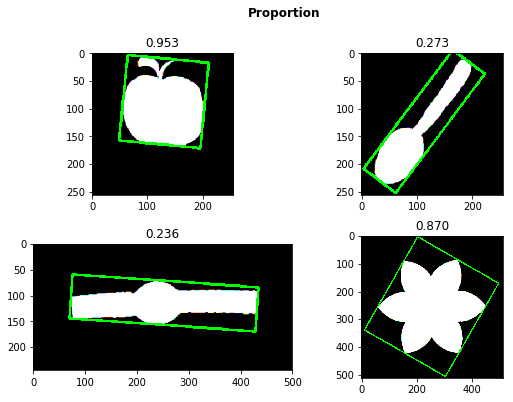

In [4]:
names = ["apple-4", "spoon-4", "watch-10", "device1-6"]
images = []
for i, n in enumerate(names):
    img = cv2.imread("converted/" + n + ".png", cv2.IMREAD_GRAYSCALE)
    f = Figure(img)
    copy = cv2.cvtColor(img,cv2.COLOR_BAYER_GR2BGR)
    rect = cv2.drawContours(copy, [f.min_rect_box], 0, (0,255,0), 3) 
    images.append({"img": rect,
                   "title": "%.3f" % f.proportion})
show("Proportion", images)

En las siguientes figuras podemos observar distintos valores para la característica __rectangularity__. Aquellas figuras que tienen un valor próximo a 1 son más parecidas al rectángulo de mínima area que la contiene. Las figuras con menor valor tienen menor similitud a dicho rectángulo.

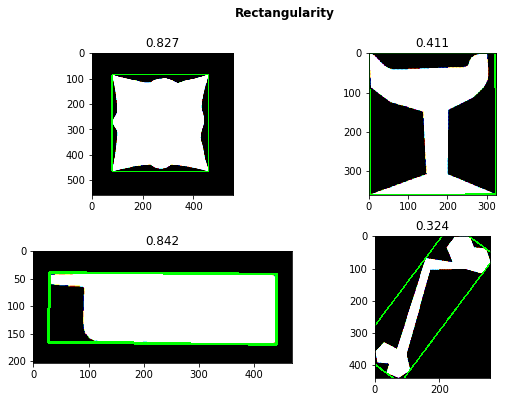

In [5]:
names = ["device3-12", "Glas-18", "cellular_phone-4", "Bone-19"]
images = []
for i, n in enumerate(names):
    img = cv2.imread("converted/" + n + ".png", cv2.IMREAD_GRAYSCALE)
    f = Figure(img)
    copy = cv2.cvtColor(img,cv2.COLOR_BAYER_GR2BGR)
    rect = cv2.drawContours(copy, [f.min_rect_box], 0, (0,255,0), 3) 
    images.append({"img": rect,
                   "title": "%.3f" % f.rectangularity})
show("Rectangularity", images)

En las siguientes figuras vamos a observar los valores de la característica __solidity__. Si la figura no llena la envoltura convexa, entonces la solidez será baja. Si por el contrario la figura llena el area de la envoltura convexa, lo solidez será próxima a 1.

En la primera dila de las siguientes figuras podemos ver que tanto el *device8* como el *device4* tienen una envoltura convexa parecida, sin embargo el *device4* cubre mayor area de la envoltura convexa. En la segunda fila ocurre algo similar entre el tenedor y la botella.

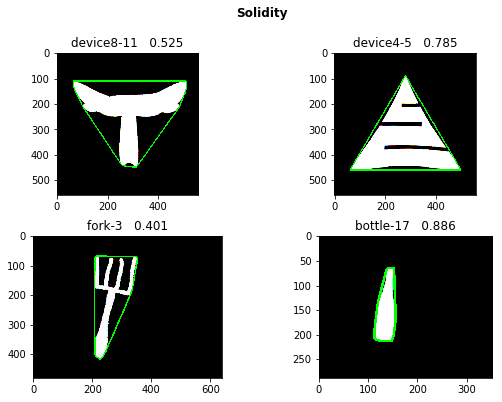

In [6]:
names = ["device8-11", "device4-5", "fork-3", "bottle-17"]
images = []
for i, n in enumerate(names):
    img = cv2.imread("converted/" + n + ".png", cv2.IMREAD_GRAYSCALE)
    f = Figure(img)
    copy = cv2.cvtColor(img,cv2.COLOR_BAYER_GR2BGR)
    hull = cv2.drawContours(copy, [f.hull], 0, (0,255,0), 3) 
    images.append({"img": hull,
                   "title": n + "   %.3f" % f.solidity})
show("Solidity", images)

En las siguientes figuras vamos a ver los valores que toma la característica __convexity__. Podemos comprobar que el escarabajo tiene un valor de convexity mucho menor que el de la campana.


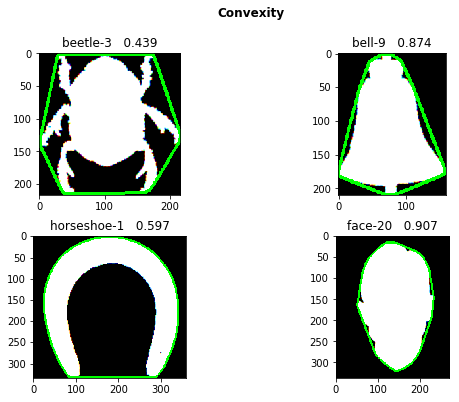

In [7]:
names = ["beetle-3", "bell-9", "horseshoe-1", "face-20"]
images = []
for i, n in enumerate(names):
    img = cv2.imread("converted/" + n + ".png", cv2.IMREAD_GRAYSCALE)
    f = Figure(img)
    copy = cv2.cvtColor(img,cv2.COLOR_BAYER_GR2BGR)
    hull = cv2.drawContours(copy, [f.hull], 0, (0,255,0), 3) 
    images.append({"img": hull,
                   "title": n + "   %.3f" % f.convexity})
show("Convexity", images)

Otra característica importante de las figuras es su __contorno__. 

Aún así almacenar el contorno como característica no nos valdría, ya que contornos de imagenes pertenecientes a la misma clase seŕian muy distintos. Para ello, vamos a utilizar lo que se conoce como __Hu moment invariants__ de la imágen.

Se trata de 7 valores extraidos del contorno que no dependen de la traslación, tamaño o rotación de la imágen.

En las siguientes imagenes podemos ver ejemplos del contorno y controno aproximado, la envoltura convexa y la envoltura convexa aproximada.

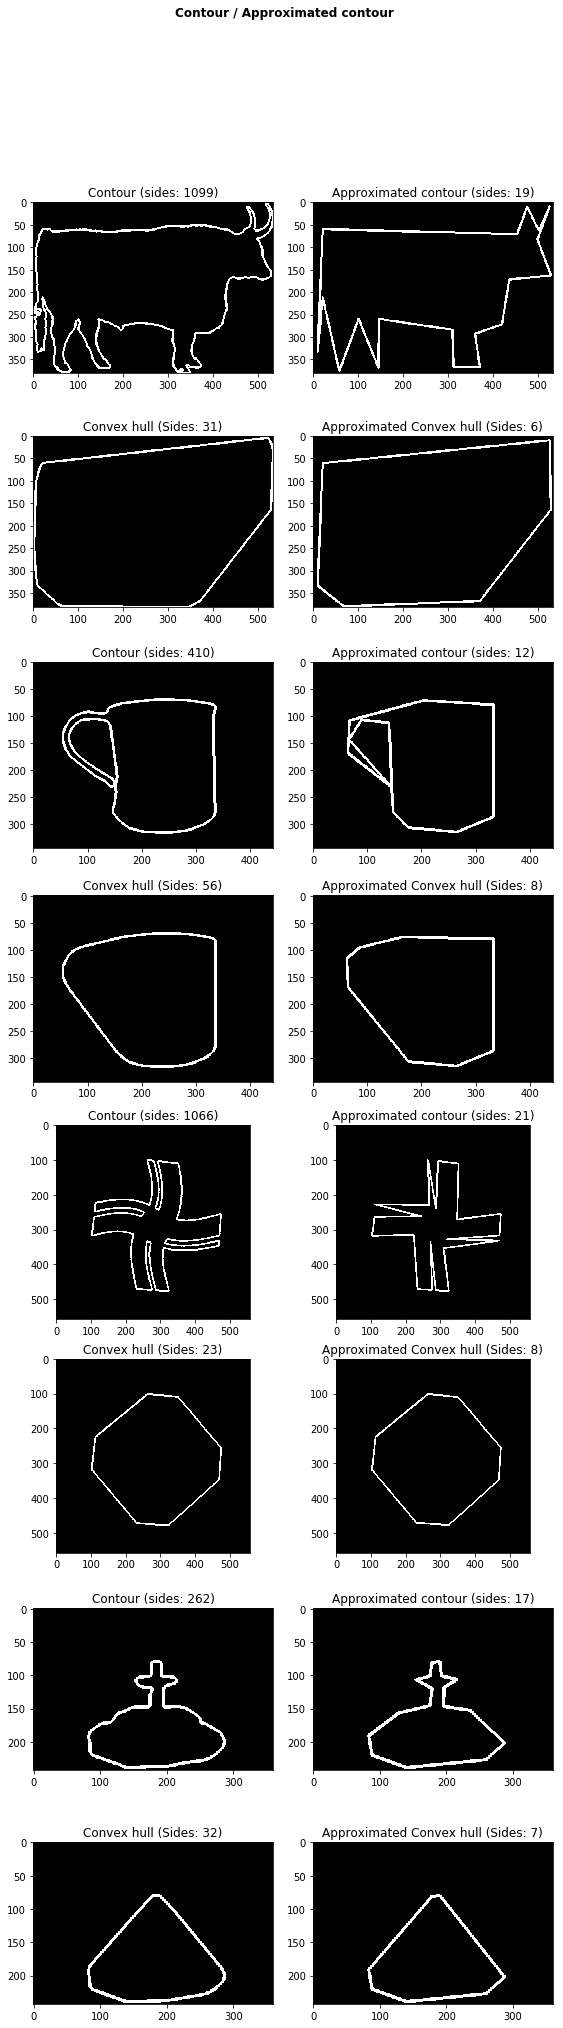

In [8]:
names = ["cattle-4", "cup-4", "device5-4", "fountain-02"]
images = []
for i, n in enumerate(names):
    img = cv2.imread("converted/" + n + ".png", cv2.IMREAD_GRAYSCALE)
    f = Figure(img)
    cnt_img = cv2.drawContours(np.zeros(img.shape), [f.cnt], 0, 255, 3)
    
    images.append({"img": cnt_img,
                   "title": "Contour (sides: %d)" % len(f.cnt),
                   "cmap": "gray"})
    
    cnt_approx_img = cv2.drawContours(np.zeros(img.shape), [f.cnt_approx], 0, 255, 3)            
    
    images.append({"img": cnt_approx_img,
                   "title": "Approximated contour (sides: %d)" % len(f.cnt_approx),
                   "cmap": "gray"})
    
    hull_img = cv2.drawContours(np.zeros(img.shape), [f.hull], 0, 255, 3)            
    
    images.append({"img": hull_img,
                   "title": "Convex hull (Sides: %d)" % len(f.hull),
                   "cmap": "gray"})
    
    
    hull_approx_img = cv2.drawContours(np.zeros(img.shape), [f.hull_approx], 0, 255, 3)            
    
    images.append({"img": hull_approx_img,
                   "title": "Approximated Convex hull (Sides: %d)" % len(f.hull_approx),
                   "cmap": "gray"})
show("Contour / Approximated contour", images, cols=2)

El siguiente método __get_data__ sirve para obetener las características de todas las imágenes con un nombre que cumpla la expresión regular *regex*.

In [9]:
from sklearn.preprocessing import StandardScaler
def get_data(regex):
    files = glob.glob(regex) 

    X = None
    y = []
    code = {}
    decode = {}
    i = 0
    for full_path in files:
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        directory, file_name = os.path.split(full_path)

        fig_name = file_name.split(".")[0]
        class_name, num  = fig_name.split("-")

        if class_name not in code.keys():
            code[class_name] = i
            decode[i] = class_name
            i += 1
        
        
        f = Figure(img, class_name)
        if X is None:
            X = f.dataframe
        else:
            X = pd.DataFrame.append(X, f.dataframe)

        
        #X.append(f.features) 
        y.append(code[class_name])
    
    return (X, y, code, decode)
    
def standard(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return (X, scaler)

def get_standard_data(regex):
    X, y, code, decode = get_data(regex)
    X_s, scaler = standard(X)
    return (X_s, y, code, decode, scaler)
    

En el siguiente ejemplo podemos apreciar la utilidad de la __longitud de la envoltura convexa aproximada__.

Por lo general el escarabajo presenta una longitud de 6, aunque en ciertas ocasiones cuando algunas patas se encuentran más escondidas, podemos obtener otros valores como 4 u 8.

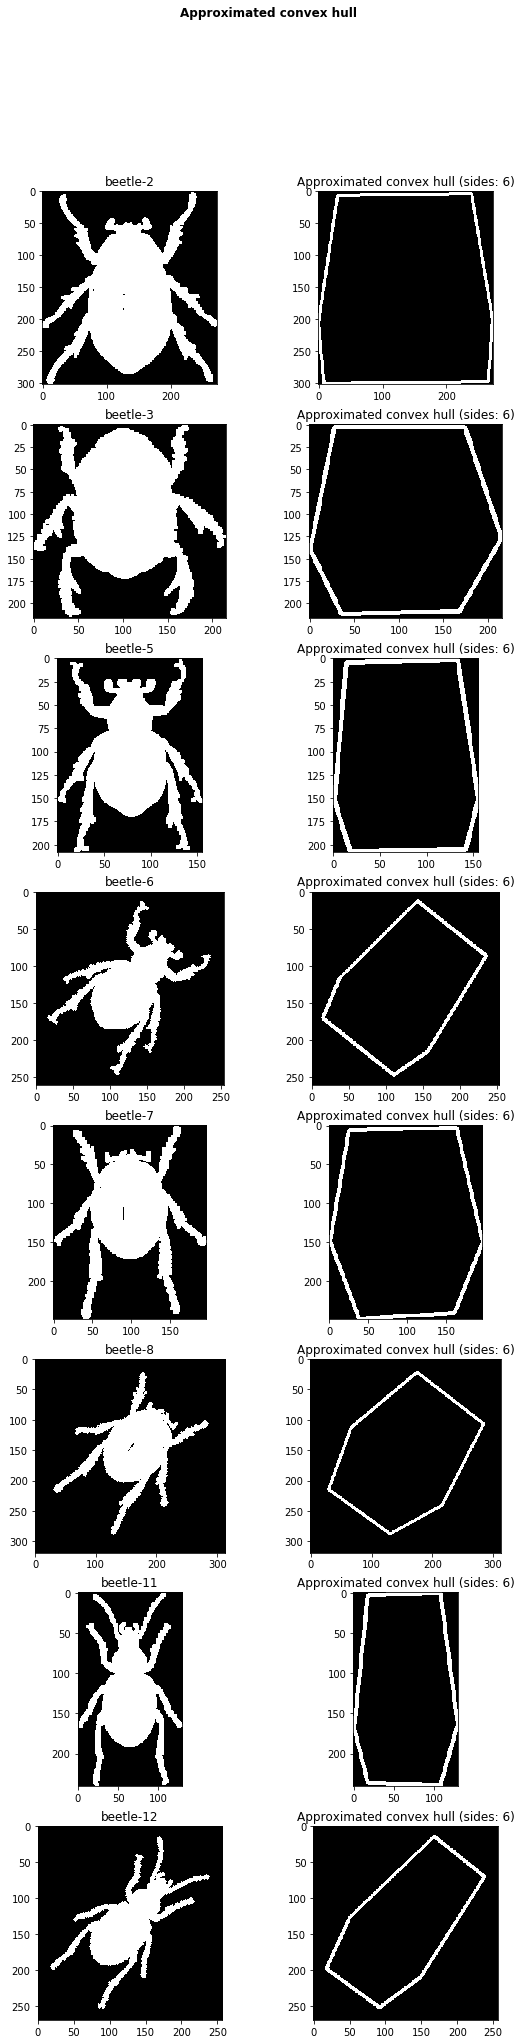

In [10]:
names = ["beetle-2","beetle-3", "beetle-5", "beetle-6", "beetle-7", "beetle-8", "beetle-11", "beetle-12"]
images = []
for i, n in enumerate(names):
    img = cv2.imread("converted/" + n + ".png", cv2.IMREAD_GRAYSCALE)
    f = Figure(img)
    cnt_img = cv2.drawContours(np.zeros(img.shape), [f.cnt], 0, 255, 3)
    
    images.append({"img": img,
                   "title": n,
                   "cmap": "gray"})
    
    hull_approx = cv2.drawContours(np.zeros(img.shape), [f.hull_approx], 0, 255, 3)            
    
    images.append({"img": hull_approx,
                   "title": "Approximated convex hull (sides: %d)" % len(f.hull_approx),
                   "cmap": "gray"})

show("Approximated convex hull", images, cols=2)

A continuación podemos ver como se comporta cada característica para cada una de las 70 clases.

Simplemente cambiando el valor de la variable *index* por el nombre de la clase.

In [11]:
X, y, code, decode = get_data("converted/*")
index = "Bone"
X.loc[index].describe()

,I_hull0,I_hull1,I_hull2,I_hull3,I_hull4,I_hull5,I_hull6,I0,I1,I2,...,I4,I5,I6,solidity,proportion,convexity,rectangularity,circularity,hull_approx_len,cnt_approx_len
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,2.000000e+01,20.000000,20.000000,20.000000,...,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,0.335521,0.088263,0.000676,0.000411,2.338379e-06,0.000155,-4.077012e-09,0.913311,0.758607,0.038695,...,0.001121,0.020606,7.510696e-05,0.490175,0.278700,0.830023,0.433038,0.190853,8.000000,17.15000
std,0.053365,0.043953,0.002057,0.001344,1.014482e-05,0.000515,1.897087e-08,0.138719,0.209444,0.030521,...,0.001273,0.013641,3.426905e-04,0.082249,0.031267,0.041507,0.077469,0.044743,0.648886,2.83354
min,0.282294,0.052921,0.000028,0.000016,3.953763e-10,0.000004,-8.097398e-08,0.541124,0.248755,0.002058,...,0.000002,0.000739,-4.528724e-04,0.375797,0.167089,0.771142,0.320532,0.126322,6.000000,9.00000
25%,0.318991,0.074889,0.000133,0.000057,5.195309e-09,0.000015,-4.855548e-11,0.896660,0.708775,0.017988,...,0.000225,0.012809,-6.916681e-07,0.446299,0.279093,0.797064,0.397193,0.169671,8.000000,16.75000
50%,0.326516,0.079605,0.000137,0.000060,5.500727e-09,0.000017,1.003844e-10,0.957190,0.829211,0.031227,...,0.000578,0.017337,4.973380e-06,0.467987,0.280215,0.838022,0.414648,0.184283,8.000000,18.00000
75%,0.326958,0.079893,0.000166,0.000071,7.447193e-09,0.000019,1.018894e-10,0.986948,0.874901,0.061384,...,0.001707,0.032492,1.621519e-05,0.516480,0.280265,0.851345,0.452213,0.196883,8.000000,18.00000
max,0.536431,0.260695,0.009333,0.006047,4.542398e-05,0.002292,1.445030e-08,1.088600,1.070928,0.122695,...,0.003805,0.045160,1.433961e-03,0.705697,0.344776,0.907071,0.639490,0.329968,9.000000,22.00000


## 3. Selección del modelo
Primero importamos lo que necesitamos de scikit-learn

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

Definimos una función que nos servirá para detectar que figuras se confunden cuando realizamos las predicciones.

In [13]:
def get_confusion(y_test, y_pred):
    from collections import defaultdict
    d = defaultdict(set)
    for k, v in zip(y_test, y_pred):
        if k != v:
            d[k].add(decode[v])

    c = dict((decode[k], tuple(v)) for k, v in d.iteritems())
    return c

A continuación vamos a probar distintos modelos y evaluarlos mediante *cross validation*.

### Support vector machine (svm)
#### LinearSVC

In [14]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
X, y, code, decode, scaler = get_standard_data("converted/*")

X_train, X_test, y_train, y_test = train_test_split(X, y)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

0.734285714286


In [15]:
scores = cross_val_score(clf, X, y, cv=20, scoring='accuracy')
print scores.mean()

0.793571428571


### SVC with RBF kernel

In [16]:
from sklearn import svm
clf = svm.SVC()

X, y, code, decode, scaler = get_standard_data("converted/*")
X_train, X_test, y_train, y_test = train_test_split(X, y)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

0.637142857143


In [17]:
scores = cross_val_score(clf, X, y, cv=20, scoring='accuracy')
print scores.mean()

0.717857142857


### SVC with polynomial kernel (degree 3)

In [18]:
from sklearn import svm
X, y, code, decode, scaler = get_standard_data("converted/*")
X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

0.174285714286


In [19]:
scores = cross_val_score(clf, X, y, cv=20, scoring='accuracy')
print scores.mean()

0.435


### Decision tree

In [20]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

X, y, code, decode, scaler = get_standard_data("converted/*")
X_train, X_test, y_train, y_test = train_test_split(X, y)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

0.745714285714


In [21]:
X, y, code, decode, scaler = get_standard_data("converted/*")

scores = cross_val_score(clf, X, y, cv=20, scoring='accuracy')                         
print scores.mean()

0.792142857143


### Neural Network 
#### Multi-layer perceptron (MLP)

In [22]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,100))

X, y, code, decode, scaler = get_standard_data("converted/*")
X_train, X_test, y_train, y_test = train_test_split(X, y)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

0.817142857143


A continuación vamos a comprobar cuales son las clases que se han confundido en la anterior predicción.

In [23]:
conf = get_confusion(y_test, y_pred)
print len(conf)
print conf

32
{'classic': ('car', 'personal_car'), 'cattle': ('turtle',), 'deer': ('horse',), 'personal_car': ('flatfish',), 'shoe': ('classic',), 'chopper': ('chicken',), 'beetle': ('deer', 'elephant'), 'chicken': ('camel',), 'ray': ('device1',), 'horse': ('deer', 'dog'), 'cup': ('Heart', 'Misk', 'apple'), 'camel': ('fly', 'chicken'), 'device1': ('beetle',), 'device0': ('chicken',), 'frog': ('ray',), 'device2': ('device5', 'device9'), 'elephant': ('camel',), 'truck': ('car',), 'hat': ('Heart', 'flatfish'), 'bird': ('butterfly', 'chicken'), 'fork': ('lmfish',), 'stef': ('dog',), 'crown': ('turtle', 'elephant', 'camel'), 'watch': ('fish', 'children'), 'pocket': ('personal_car',), 'guitar': ('spoon', 'key'), 'bat': ('bird',), 'Misk': ('jar', 'frog'), 'tree': ('guitar', 'fish', 'fountain', 'bird', 'dog'), 'Comma': ('bird',), 'lmfish': ('fish',), 'octopus': ('device5', 'camel', 'teddy')}


Mediante prueba y error se ha llegado a la conclusión de que si la red neuronal está formada por dos capas y cada una de ellas tiene 100 neuronas aproximadamente, obtenemos un porcentaje de acierto de 84%-85%. Este es el mayor porcentaje que hemos obtenido con cada uno de los distintos modelos probados.

In [25]:
X, y, code, decode, scaler = get_standard_data("converted/*")
clf = MLPClassifier(hidden_layer_sizes=(100,100))
scores = cross_val_score(clf, X, y, cv=20, scoring='accuracy')                                                 
print scores.mean()

0.849285714286


## 4. Trabajo Futuro

- Estudiar otro tipo de caracteristicas y método de extracción. Comprobar si ayudan a mejorar nuestro modelo.

    - Fourier descriptors
    - Curvature Scale Space (CSS)
    - Morphological skeleton
    
    
- Estudiar las redes neuronales y optimizar la arquitectura de la red. Se trata del modelo que está arrojando mejores resultados.

- Usar otra librería como por ejemplo *keras* que permita el uso de GPU.

### 5. Referencias
https://www.math.uci.edu/icamp/summer/research_11/park/shape_descriptors_survey_part2.pdf
https://www.cs.toronto.edu/~kyros/courses/2503/Handouts/features.pdf
http://www.pyimagesearch.com/2014/05/19/building-pokedex-python-comparing-shape-descriptors-opencv/
https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm
http://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter2.pdf
https://es.slideshare.net/Jaddu44/image-feature-extraction
http://www.intelligence.tuc.gr/~petrakis/courses/computervision/binary.pdf
http://vgg.fiit.stuba.sk/2013-04/css-%E2%80%93-curvature-scale-space-in-opencv/
https://www.math.uci.edu/icamp/summer/research_11/park/shape_descriptors_survey_part3.pdf
https://www.ijsr.net/archive/v4i3/SUB152653.pdf
http://informatik.hsnr.de/~dalitz/data/publications/broken-fourier.pdf
https://www.it.uu.se/edu/course/homepage/bild1/vt13/lecture_objectdecriptors.pdf
http://www.m-hikari.com/imf-password2009/25-28-2009/bribiescaIMF25-28-2009.pdf